### TO DO-P.K: Cases, death, recovery per day


## Table of contents
(only works for local jupyter instances)

1. [Research question](#Research-question)
2. [Proposed models](#Proposed-models-(PGM-+-generative-process))
3. [Exploratory analysis](#Initial-notebook-(descriptive-stats,-data-preparation))
    1. [Part1](#Part1:)
    2. [Part2](#Part-2:)
5. [Models](#Models)

# Research question


*   Importance of reduce mobility in coronavirus exposure: how improved is forecasting when using mobility data?

*   Relationship between demographic data and spreading.




# Proposed models (PGM + generative process)

* Start with AR model (slide 7, y would be a composition of SIR).

*   LDS model where the distribution of the latent variables depend on the mobility distribution (check shape of data!) (imputation?). Temporal models slide 19.

* Or a Extended Kalman filter with the non-linear function from the mobility/demography.

*   HMM where the emision distribution is a non-linear function that depends on mobility/demography (imputation?) + the latent variable.




In [0]:
from IPython.display import Image
from IPython.core.display import HTML

The SIR model is commonly used in epidemiology and usually represented by a set of ODEs. However, our goal is to imitate this model without the use of ODEs. A depiction of the SIR model:


In [0]:
Image(url="https://raw.githubusercontent.com/jonasvestergaardjensen/MBML/master/SIR.png")

S is the number of people that can be infected with the disease, I is the number of infected people and R is the number of recovered people, which also includes deaths.

The first of our models is the regular Kalman filter:

In [0]:
Image(url="https://raw.githubusercontent.com/jonasvestergaardjensen/MBML/master/kalman_filter.png")

where $y_t = \hat i_t$, i.e. the observed number of infected at day *t*, and $\boldsymbol{h_t} = (s_t, i_t)$, i.e. the true number of suspectible and infected at day *t*.

For the Kalman filter we assume that the latent variables and the response variable follows gaussian distributions:
\begin{align}
\textbf{h}_t &\sim \mathcal{N}(\boldsymbol{B} \textbf{h}_{t-1}, \boldsymbol{R})
\end{align}
\begin{align}
y_{t} &\sim \mathcal{N}(\boldsymbol{c}^{T}\boldsymbol{h}_t, \sigma^2)\\
\end{align}
where $\boldsymbol{c} = (0, 1)$. 

The generative process is:
1. Draw $\boldsymbol{B} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\tau})$
2. Draw $\boldsymbol{R} \sim \mathcal{HalfCauchy}(\boldsymbol{\alpha})$
3. For each time *t*
  1. Draw $\textbf{h}_t \sim \mathcal{N}(\boldsymbol{B} \textbf{h}_{t-1}, \boldsymbol{R})$
  2. Draw $y_{t} \sim \mathcal{N}(\boldsymbol{c}^{T}\boldsymbol{h}_t, \sigma^2)$

$\tau$, $\alpha$ and $\sigma$ are hyperparameters. 

The next of our models is the extended Kalman filter:

In [0]:
Image(url="https://raw.githubusercontent.com/jonasvestergaardjensen/MBML/master/extended_kalman_filter.png")

In the extended Kalman filter we replace $\boldsymbol{B}$ and $\boldsymbol{c}$ with non-linear functions *f* and *g*:\
\begin{align}
\textbf{h}_t &\sim \mathcal{N}(f(\boldsymbol{h}_{t-1}), \boldsymbol{R})
\end{align}
\begin{align}
y_{t} &\sim \mathcal{N}(g(\boldsymbol{h}_t), \sigma^2)\\
\end{align}

The generative process is:
1. Draw $\boldsymbol{R} \sim \mathcal{HalfCauchy}(\boldsymbol{\alpha})$
2. For each time *t*
  1. Draw $\textbf{h}_t \sim \mathcal{N}(f(\boldsymbol{h}_{t-1}), \boldsymbol{R})$
  2. Draw $y_{t} \sim \mathcal{N}(g(\boldsymbol{h}_t), \sigma^2)$

$\alpha$ and $\sigma$ are hyperparameters. 

The last of our models is the extended Kalman filter with inputs:

In [0]:
Image(url="https://raw.githubusercontent.com/jonasvestergaardjensen/MBML/master/extended_kalman_filter_with_input.png")

where $\boldsymbol{x}_t$ is a vector of observed values for day *t* for the mobility variables in our data. The latent variables and the response variable for the extended kalman filter with inputs are assumed to follow the following distributions:
\begin{align}
\textbf{h}_t \sim \mathcal{N}(f(\boldsymbol{h}_{t-1}, \boldsymbol{x}_t), \boldsymbol{R})
\end{align}
\begin{align}
y_{t} \sim \mathcal{N}(g(\boldsymbol{h}_t), \sigma^2)\\
\end{align}

The generative process is:
1. Draw $\boldsymbol{R} \sim \mathcal{HalfCauchy}(\boldsymbol{\alpha})$
2. For each time *t*
  1. Draw $\textbf{h}_t \sim \mathcal{N}(f(\boldsymbol{h}_{t-1}, \boldsymbol{x}_t), \boldsymbol{R})$
  2. Draw $y_{t} \sim \mathcal{N}(g(\boldsymbol{h}_t), \sigma^2)$

$\alpha$ and $\sigma$ are hyperparameters. 


# Initial notebook (descriptive stats, data preparation)

## Part1:
###WorldWide COVID-19 Dataset:

In [0]:
!pip install numpyro

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 256kB 9.0MB/s 
     |████████████████████████████████| 25.4MB 164kB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297709 sha256=94c4f53d29119363e9f23f2cbe4f70660edf58ba7e19025701ca08d9ec4c6a19
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
  Created wheel for fastcache: filename=fastcache-1.1.0-cp36-cp36m-linux_x86_64.whl size=39200 sha256=e3bc99b5bd25eb6351940b679b732500af00c46dc8ba0290e9bc36309ebcedc3
  Stored in directory: /root/.cache/pip/wheels/6a/80/bf/30024738b03fa5aa521e2a2ac952a8d77d0c65e68d92bcd3b6
Successfully built jax fastcache
  Found existing installation: jax 0.1.64
    Uninstalling jax-0.1.64:
      Successfully uninstalled jax-0.1.64
  Found existing installation: jaxlib 0.1.45
    Uninstalling jaxlib-0.1.45:
      Successfully uninstalled jaxlib-0.1.45


In [0]:
# The below is helpful to upload local file to the colab 
from google.colab import files

# I am more fan of plotly than matplo.....
import plotly.express as px
import plotly.graph_objects as go

# Pandas is needed in most of the cases:
import pandas as pd

# The code below will make the GUI to upload the local file
#uploaded = files.upload()

In [0]:
# these imports are separated in case you just
# want to run the initial analysis
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

### Data Import:

In [0]:
# I am importing the dataset of whole countries, while parsing it's date column:
data_covid19=pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv", parse_dates=['Date'])

# A brief look on the column types:
data_covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19261 entries, 0 to 19260
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       19261 non-null  datetime64[ns]
 1   Country    19261 non-null  object        
 2   Confirmed  19261 non-null  int64         
 3   Recovered  19261 non-null  int64         
 4   Deaths     19261 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 752.5+ KB


In [0]:
# Look on the tail of data 
data_covid19.tail()

,Date,Country,Confirmed,Recovered,Deaths
17015,2020-04-22,West Bank and Gaza,474,71,4
17016,2020-04-22,Western Sahara,6,0,0
17017,2020-04-22,Yemen,1,0,0
17018,2020-04-22,Zambia,74,35,3
17019,2020-04-22,Zimbabwe,28,2,4


### Country Selection: Spain!

In [0]:
# here I am filtering the coutntry and subseting the Spain dataset
covid19_sp = data_covid19[data_covid19['Country'] == 'Spain']
covid19_sp.tail(10)
print(len(covid19_sp))

93


In [0]:
value=covid19_sp.loc[:,'Confirmed'].diff()
covid19_sp.loc[:, 'Confirmed_daily'] = value
covid19_sp.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Country,Confirmed,Recovered,Deaths,Confirmed_daily
156,2020-01-22,Spain,0,0,0,NaN
341,2020-01-23,Spain,0,0,0,0.0
526,2020-01-24,Spain,0,0,0,0.0
711,2020-01-25,Spain,0,0,0,0.0
896,2020-01-26,Spain,0,0,0,0.0
1081,2020-01-27,Spain,0,0,0,0.0
1266,2020-01-28,Spain,0,0,0,0.0
1451,2020-01-29,Spain,0,0,0,0.0
1636,2020-01-30,Spain,0,0,0,0.0
1821,2020-01-31,Spain,0,0,0,0.0


### Visualize

In [0]:
# Plotly plot of the date, versus the "Confirmed" Column- It should be noted that the data are "Comulative"...
fig = px.line(covid19_sp, x="Date", y="Confirmed")
fig.show()

In [0]:
fig = px.line(covid19_sp, x="Date", y="Confirmed_daily")
fig.show()

In [0]:
# Plotly plot of the date, versus the "Recovered" Column- It should be noted that the data are "Comulative"...
fig = px.line(covid19_sp, x="Date", y="Recovered")
fig.show()

In [0]:
# Plotly plot of the date, versus the "Deaths" Column- It should be noted that the data are "Comulative"...
fig = px.line(covid19_sp, x="Date", y="Deaths")
fig.show()

## Part 2:
### Denamrk Dataset, More Columns and Information:



### Data Import:

In [0]:
# Here I am using the REST API at the covid19data.dk website to query the data
data_DK=pd.read_json("https://api.covid19data.dk:443/ssi_cases", convert_dates=['timestamp'])
data_DK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           41 non-null     datetime64[ns]
 1   cases               41 non-null     int64         
 2   new_cases           41 non-null     int64         
 3   deaths              40 non-null     float64       
 4   hospitalized_total  2 non-null      float64       
 5   hospitalized_today  38 non-null     float64       
 6   critical_today      9 non-null      float64       
 7   respirator_today    9 non-null      float64       
 8   removed_total       22 non-null     float64       
 9   notes               2 non-null      object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 3.3+ KB


In [0]:
data_DK.tail(10)

,timestamp,cases,new_cases,deaths,hospitalized_total,hospitalized_today,critical_today,respirator_today,removed_total,notes
31,2020-04-14 07:15:00,6496,178,299.0,NaN,380.0,NaN,NaN,2515.0,None
32,2020-04-15 07:15:00,6681,185,309.0,NaN,362.0,89.0,75.0,2748.0,None
33,2020-04-16 08:00:00,6879,198,321.0,NaN,353.0,92.0,72.0,3023.0,None
34,2020-04-17 08:00:00,7073,194,336.0,NaN,350.0,93.0,74.0,3389.0,None
35,2020-04-18 08:00:00,7242,169,346.0,NaN,317.0,87.0,76.0,3847.0,None
36,2020-04-19 08:00:00,7384,142,355.0,NaN,319.0,84.0,73.0,4141.0,None
37,2020-04-20 08:00:00,7515,131,364.0,NaN,336.0,84.0,72.0,4312.0,None
38,2020-04-21 08:00:00,7695,180,370.0,NaN,335.0,81.0,72.0,4700.0,None
39,2020-04-22 08:00:00,7912,217,384.0,NaN,324.0,80.0,68.0,5087.0,None
40,2020-04-23 08:00:00,8073,161,394.0,NaN,319.0,74.0,61.0,5384.0,None


In [0]:
# Here I am selecting the relevant columns, the columns I think will be used:
data_DK_sel=data_DK[["timestamp","cases","deaths","hospitalized_today"]]

In [0]:
# here, I am melting the columns, this the Python equivalent of pivot_longer in R - Here the new situation column will be catagery of the situation
# and the value will be the number of the situation:
data_DK_sel_melted=data_DK_sel.melt(id_vars=['timestamp'], var_name='situation')
data_DK_sel_melted.head(10)

,timestamp,situation,value
0,2020-03-12 07:30:00,cases,615.0
1,2020-03-13 07:30:00,cases,785.0
2,2020-03-16 08:00:00,cases,898.0
3,2020-03-17 08:00:00,cases,960.0
4,2020-03-18 08:00:00,cases,1044.0
5,2020-03-19 08:00:00,cases,1132.0
6,2020-03-20 08:00:00,cases,1226.0
7,2020-03-21 08:00:00,cases,1326.0
8,2020-03-22 08:00:00,cases,1395.0
9,2020-03-23 08:00:00,cases,1450.0


### Visulization

In [0]:
fig = px.line(data_DK_sel_melted, x="timestamp", y="value", color="situation", facet_row="situation")
fig.update_yaxes(matches=None)
fig.show()

In [0]:
# The below is helpful to upload local file to the colab 
from google.colab import files

# I am more fan of plotly than matplo.....
import plotly.express as px

# Pandas is needed in most of the cases:
import pandas as pd

# The code below will make the GUI to upload the local file
#uploaded = files.upload()

In [0]:
uploaded = files.upload()

Saving Global_Mobility_Report.csv to Global_Mobility_Report.csv


In [0]:
import io
import pandas as pd
data_mobility = pd.read_csv(io.BytesIO(uploaded['Global_Mobility_Report.csv']), parse_dates=['date'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
import io
data_mobility_apple = pd.read_csv(io.BytesIO(uploaded['applemobilitytrends-2020-04-30.csv']))

In [0]:
data_mobility_apple.head()

,geo_type,region,transportation_type,alternative_name,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,country/region,Albania,driving,NaN,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,129.41,102.24,...,19.29,22.62,21.61,21.98,23.07,23.94,19.49,21.78,23.66,25.11,25.02,25.20,24.11,20.54,22.54,26.40,26.03,26.43,26.70,26.32,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51,33.59,31.69,33.94,30.22,25.22,30.39,37.39,36.69,35.90,38.09
1,country/region,Albania,walking,NaN,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,84.52,96.63,...,22.64,25.93,25.88,25.42,23.03,28.27,24.69,20.26,22.90,25.93,23.50,26.65,27.76,24.90,23.92,31.13,25.80,29.81,28.96,27.29,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72,34.46,35.39,34.80,34.63,29.00,35.22,41.83,37.53,41.49,38.25
2,country/region,Argentina,driving,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,88.20,92.28,...,8.74,10.08,10.76,14.86,14.58,15.45,13.34,9.92,14.59,12.65,15.79,16.48,17.15,15.13,11.53,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67,27.25,27.61,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45
3,country/region,Argentina,walking,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,69.12,93.42,...,6.96,8.36,8.05,10.92,10.53,11.30,10.73,7.77,11.37,9.79,11.78,11.23,12.44,10.97,9.12,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44,19.01,18.47,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80
4,country/region,Australia,driving,NaN,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,98.27,101.79,...,66.41,62.49,60.19,57.96,59.90,48.25,36.69,51.18,51.92,52.04,51.54,54.23,41.58,33.34,51.75,53.17,55.01,59.24,33.19,36.00,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93,58.06,59.69,62.87,47.84,41.89,55.39,59.09,59.46,59.46,63.12


In [0]:
apple_sel= data_mobility_apple.drop(['geo_type',"alternative_name"], axis=1)
apple_sel.head()

,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,Albania,driving,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,129.41,102.24,88.09,88.17,...,19.29,22.62,21.61,21.98,23.07,23.94,19.49,21.78,23.66,25.11,25.02,25.20,24.11,20.54,22.54,26.40,26.03,26.43,26.70,26.32,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51,33.59,31.69,33.94,30.22,25.22,30.39,37.39,36.69,35.90,38.09
1,Albania,walking,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,84.52,96.63,87.38,81.49,...,22.64,25.93,25.88,25.42,23.03,28.27,24.69,20.26,22.90,25.93,23.50,26.65,27.76,24.90,23.92,31.13,25.80,29.81,28.96,27.29,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72,34.46,35.39,34.80,34.63,29.00,35.22,41.83,37.53,41.49,38.25
2,Argentina,driving,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,88.20,92.28,98.15,98.96,...,8.74,10.08,10.76,14.86,14.58,15.45,13.34,9.92,14.59,12.65,15.79,16.48,17.15,15.13,11.53,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67,27.25,27.61,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45
3,Argentina,walking,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,69.12,93.42,111.49,107.02,...,6.96,8.36,8.05,10.92,10.53,11.30,10.73,7.77,11.37,9.79,11.78,11.23,12.44,10.97,9.12,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44,19.01,18.47,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80
4,Australia,driving,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,98.27,101.79,105.38,107.29,...,66.41,62.49,60.19,57.96,59.90,48.25,36.69,51.18,51.92,52.04,51.54,54.23,41.58,33.34,51.75,53.17,55.01,59.24,33.19,36.00,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93,58.06,59.69,62.87,47.84,41.89,55.39,59.09,59.46,59.46,63.12


In [0]:
apple_sel_tidy= apple_sel.melt(id_vars=['region',"transportation_type"], var_name='date')
apple_sel_tidy.head()


,region,transportation_type,date,value
0,Albania,driving,2020-01-13,100.0
1,Albania,walking,2020-01-13,100.0
2,Argentina,driving,2020-01-13,100.0
3,Argentina,walking,2020-01-13,100.0
4,Australia,driving,2020-01-13,100.0


In [0]:
apple_sel_tidy['date']  = pd.to_datetime(apple_sel_tidy['date'])


In [0]:
apple_spain = apple_sel_tidy[apple_sel_tidy['region'] == 'Spain']
apple_spain.head()

,region,transportation_type,date,value
123,Spain,driving,2020-01-13,100.00
124,Spain,transit,2020-01-13,100.00
125,Spain,walking,2020-01-13,100.00
1281,Spain,driving,2020-01-14,101.06
1282,Spain,transit,2020-01-14,98.32


In [0]:
import plotly.express as px
fig = px.scatter(apple_spain, x="date", y="value", color="transportation_type")
fig.show()

In [0]:
data_mobility.head()

In [0]:
data_mobility.info()

## Country: Denmark

In [0]:
data_mobility_dk = data_mobility.loc[(data_mobility['country_region'] == "Denmark")]
data_mobility_sp = data_mobility.loc[(data_mobility['country_region'] == "Spain")]

data_mobility_dk.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
14843,DK,Denmark,NaN,NaN,2020-02-15,-2.0,-1.0,-4.0,2.0,-6.0,0.0
14844,DK,Denmark,NaN,NaN,2020-02-16,-7.0,-7.0,-33.0,-5.0,-6.0,1.0
14845,DK,Denmark,NaN,NaN,2020-02-17,-3.0,-1.0,0.0,-3.0,-2.0,1.0
14846,DK,Denmark,NaN,NaN,2020-02-18,1.0,1.0,9.0,-1.0,-1.0,1.0
14847,DK,Denmark,NaN,NaN,2020-02-19,0.0,0.0,12.0,-2.0,-1.0,1.0


In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(
                x=data_mobility_dk['date'],
                y=data_mobility_dk['retail_and_recreation_percent_change_from_baseline'],
                mode='markers'
))
fig.show()

In [0]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['retail_and_recreation_percent_change_from_baseline'],
                    mode='markers',
                    name='Retail and Recreation'))
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['grocery_and_pharmacy_percent_change_from_baseline'],
                    mode='markers',
                    name='Grocery and Pharmacy'))
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['parks_percent_change_from_baseline'],
                    mode='markers',
                    name='Parks'))
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['transit_stations_percent_change_from_baseline'],
                    mode='markers',
                    name='Transit Stations'))
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['workplaces_percent_change_from_baseline'],
                    mode='markers',
                    name='Workplace'))
fig.add_trace(go.Scatter(x=data_mobility_dk['date'], y=data_mobility_dk['residential_percent_change_from_baseline'],
                    mode='markers',
                    name='Residentia Area'))


fig.update_layout(
    autosize=False,
    width=1250,
    height=800
    )

fig.show()

## Country: Spain

In [0]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['retail_and_recreation_percent_change_from_baseline'],
                    mode='markers',
                    name='Retail and Recreation'))
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['grocery_and_pharmacy_percent_change_from_baseline'],
                    mode='markers',
                    name='Grocery and Pharmacy'))
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['parks_percent_change_from_baseline'],
                    mode='markers',
                    name='Parks'))
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['transit_stations_percent_change_from_baseline'],
                    mode='markers',
                    name='Transit Stations'))
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['workplaces_percent_change_from_baseline'],
                    mode='markers',
                    name='Workplace'))
fig.add_trace(go.Scatter(x=data_mobility_sp['date'], y=data_mobility_sp['residential_percent_change_from_baseline'],
                    mode='markers',
                    name='Residentia Area'))


fig.update_layout(
    autosize=False,
    width=1250,
    height=800
    )

fig.show()

## Apple Mobility Data

In [0]:
uploaded = files.upload()

NameError: ignored

## Models
AR(1) model, as seen in the lectures:
\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

In [0]:
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = beta*z_prev + tau*noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

def model(T, obs=None):
    # Define priors over beta, tau, noises, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=.1))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection, scale=sigma), obs=obs)

Let's train the model with DK data and test it with the SP data.

In [0]:
covid19_sp = data_covid19[data_covid19['Country'] == 'Spain']
covid19_dk = data_covid19[data_covid19['Country'] == 'Denmark']
y_train = covid19_dk.iloc[:,2:].values
N, D = y_train.shape
y_test = covid19_sp.iloc[:,2:].values

In [0]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=y_train.shape[0], obs=y_train[:,0])

sample: 100%|██████████| 4000/4000 [00:18<00:00, 215.28it/s, 17 steps of size 5.00e-03. acc. prob=0.04]


In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples

{'beta': DeviceArray([1.1305135, 1.1305135, 1.1305135, ..., 1.1203723, 1.1211245,
              1.1204966], dtype=float32),
 'noises': DeviceArray([[ 1.4313952 , -1.7439265 , -0.4238562 , ..., -1.1553261 ,
               -1.0422912 ,  0.22703256],
              [ 1.4313952 , -1.7439265 , -0.4238562 , ..., -1.1553261 ,
               -1.0422912 ,  0.22703256],
              [ 1.4313952 , -1.7439265 , -0.4238562 , ..., -1.1553261 ,
               -1.0422912 ,  0.22703256],
              ...,
              [ 1.262662  , -1.8060595 , -0.29706687, ..., -1.290461  ,
               -1.0817606 ,  0.22435659],
              [ 1.2629935 , -1.8078269 , -0.29793602, ..., -1.2898142 ,
               -1.0764444 ,  0.22684656],
              [ 1.267328  , -1.8064681 , -0.3051621 , ..., -1.2841693 ,
               -1.0817542 ,  0.22832263]], dtype=float32),
 'sigma': DeviceArray([2959.893 , 2959.893 , 2959.893 , ..., 2966.3604, 2965.274 ,
              2966.2542], dtype=float32),
 'tau': DeviceArray([

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

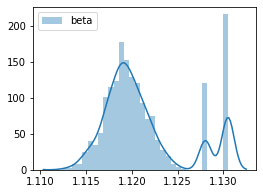

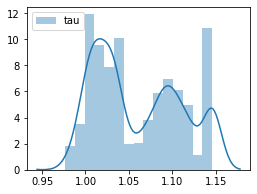

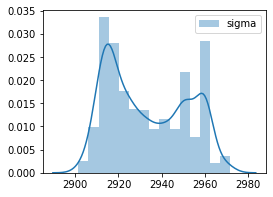

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
from numpyro.infer import Predictive

predictive = Predictive(model, num_samples=1000,
                        return_sites=("tau", "beta", "sigma", "noises"))
samples = predictive(rng_key_, T=y_train.shape[0], obs=y_train[:,0])

In [0]:
z_1 = np.float32(y_test[37])

For each set of sampled values, propagate the autoregresive model for z_1 (arbitrarly chosen)

In [0]:
fig = go.Figure()
betas = samples["beta"]
taus = samples["tau"]
noiseses = samples["noises"]
sigmas = samples["sigma"]
for tau, beta, sigma, noises in zip(*[taus, betas, sigmas, noiseses]):
    carry = (beta, z_1, tau)
    z_collection = [z_1]
    carry, zs_exp = lax.scan(f, carry, noises, 91)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
     # I wonder if something is missing here between z and y
    fig.add_trace(go.Scatter(x=covid19_sp["Date"], y=z_collection, mode="lines"))
fig

## Action Points:

## Peyman


In [0]:
covid19_dk = data_covid19[data_covid19['Country'] == 'Denmark']
value=covid19_dk.loc[:,'Confirmed'].diff()
covid19_dk.loc[:, 'Confirmed_daily'] = value
covid19_dk=covid19_dk[covid19_dk['Confirmed_daily']>0]
covid19_dk.head(10)
covid19_dk.tail(10)
fig = px.bar(covid19_dk, x="Date", y="Confirmed_daily")
fig.show()

In [0]:
fig = px.bar(covid19_dk, x="Date", y="Confirmed_daily")
fig.show()

In [0]:
data_covid19=pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv", parse_dates=['Date'])
covid19_dk = data_covid19[data_covid19['Country'] == 'Denmark']
value=covid19_dk.loc[:,'Confirmed'].diff()
covid19_dk.loc[:, 'Confirmed_daily'] = value
covid19_dk=covid19_dk[covid19_dk['Confirmed_daily']>0]
fig = px.bar(covid19_dk, x="Date", y="Confirmed_daily")
fig.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### JV: Simple case of KF to get to know the example

In [0]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

from torch.distributions import constraints
import numpy

Linear dynamical system / Kalman filter from lecture 7 part 4. The model is made for making imputations on a multivariate y. The example is maybe a bit complicated, but the only one of a LDS from the lectures, that is not an AR model. 

In [0]:
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = beta*z_prev + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

I think it is interesting for us to use forecasting to see how well our models
are doing.

In [1]:
def singlevariate_kf(T, T_forecast, obs=None):
    """Define Kalman Filter in a single variate fashion.

    Parameters
    ----------
    T:  int
    T_forecast: int
        Times to forecast ahead.
    obs: np.array
        observed variable (infected, deaths...)

    """
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0.0, scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=0.1))
    noises = numpyro.sample(
        "noises", fn=dist.Normal(0, 1.0), sample_shape=(T + T_forecast - 2,)
    )
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=0.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=0.1))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    # Sample the observed y (y_obs) and missing y (y_mis)
    numpyro.sample(
        name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs
    )
    numpyro.sample(
        name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None
    )


def multivariate_kf(T, T_forecast, obs=None):
    """Define Kalman Filter in a multivariate fashion.

    The "time-series" are correlated. To define these relationships in
    a efficient manner, the covarianze matrix of h_t (or, equivalently, the
    noises) is drown from a Cholesky decomposed matrix.

    Parameters
    ----------
    T:  int
    T_forecast: int
    obs: np.array
       observed variable (infected, deaths...)

    """
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=0.1))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 1,),
    )

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T + T_forecast - 1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    # Sample the observed y (y_obs) and missing y (y_mis)
    numpyro.sample(
        name="y_obs1", fn=dist.Normal(loc=z_collection[:T, 0], scale=sigma), obs=obs[:, 0]
    )
    numpyro.sample(
        name="y_pred1", fn=dist.Normal(loc=z_collection[T:, 0], scale=sigma), obs=None
    )
    numpyro.sample(
        name="y_obs2", fn=dist.Normal(loc=z_collection[:T, 1], scale=sigma), obs=obs[:, 1]
    )
    numpyro.sample(
        name="y_pred2", fn=dist.Normal(loc=z_collection[T:, 1], scale=sigma), obs=None
    )

In [0]:
observed = covid19_dk.loc[:, 'Confirmed'].to_numpy()
observed

array([    1,     3,     4,     6,    11,    24,    37,    92,   264,
         444,   617,   804,   836,   875,   933,  1025,  1116,  1225,
        1337,  1420,  1514,  1572,  1718,  1862,  2023,  2200,  2366,
        2564,  2755,  3039,  3290,  3573,  3946,  4269,  4561,  4875,
        5266,  5597,  5830,  6014,  6191,  6369,  6513,  6706,  6876,
        7074,  7268,  7437,  7580,  7711,  7891,  8108,  8271,  8408,
        8643,  8773,  8896,  9049,  9206,  9356,  9509,  9605,  9721,
        9868, 10019, 10136])

In [0]:
T_forecast = 15
T = len(observed)

### Single variate Kalman Filter
**TODO**: I know I should be doing this on plotly for consistence, but I don't want to work on the visualizatiins right now.


In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=singlevariate_kf)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, obs=observed)

sample: 100%|██████████| 2000/2000 [00:29<00:00, 68.22it/s, 1023 steps of size 2.45e-03. acc. prob=0.96] 


Let's not pollute too much the notebook.


In [0]:
#mcmc.print_summary()

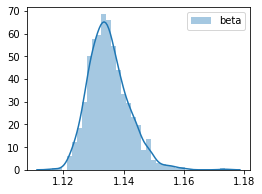

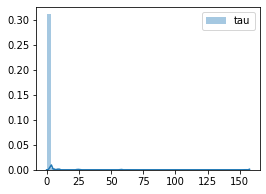

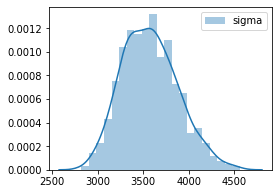

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

Not looking half bad. **$\tau$ maybe was too high??**




In [0]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

In [0]:
y_pred_mean

DeviceArray([17908.26 , 20177.928, 23095.258, 25993.94 , 29697.02 ,
             33662.195, 38193.4  , 43374.633, 49135.52 , 55730.05 ,
             63527.438, 72091.38 , 81927.73 , 93049.73 ], dtype=float32)

In [0]:
plt.rcParams['figure.figsize'] = (16, 10)

**TODO**: plot also the observed variable `y_obs` in the model (would that make sense? I think so)

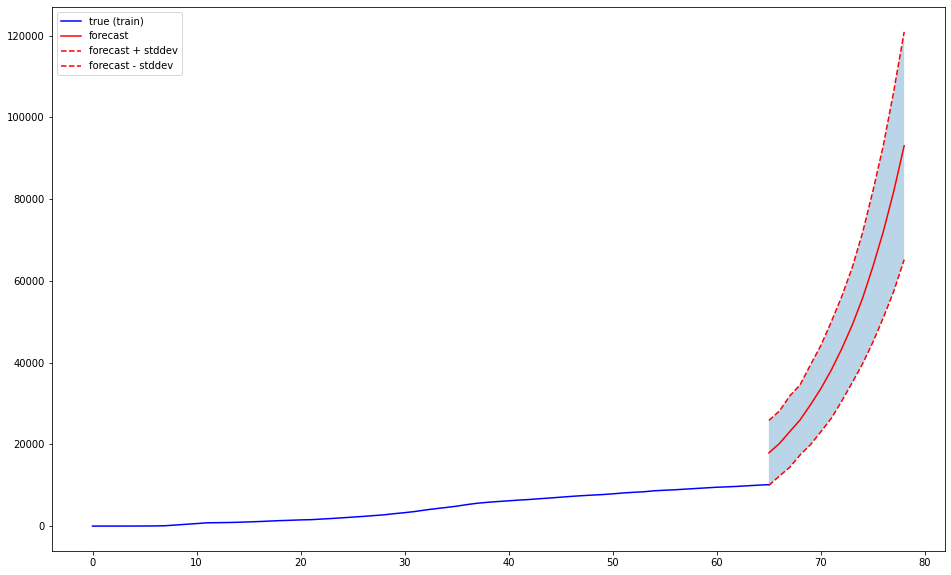

In [0]:
plt.plot(range(T), observed, "b-")
plt.plot(range(T-1, T+T_forecast-2), y_pred_mean, "r-")
plt.plot(range(T-1, T+T_forecast-2), y_pred_025, "r--")
plt.plot(range(T-1, T+T_forecast-2), y_pred_975, "r--")
plt.fill_between(range(T-1, T+T_forecast-2), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

Not the best prediction in the world. At least it has exponential form (the training part has also exp form, of course)

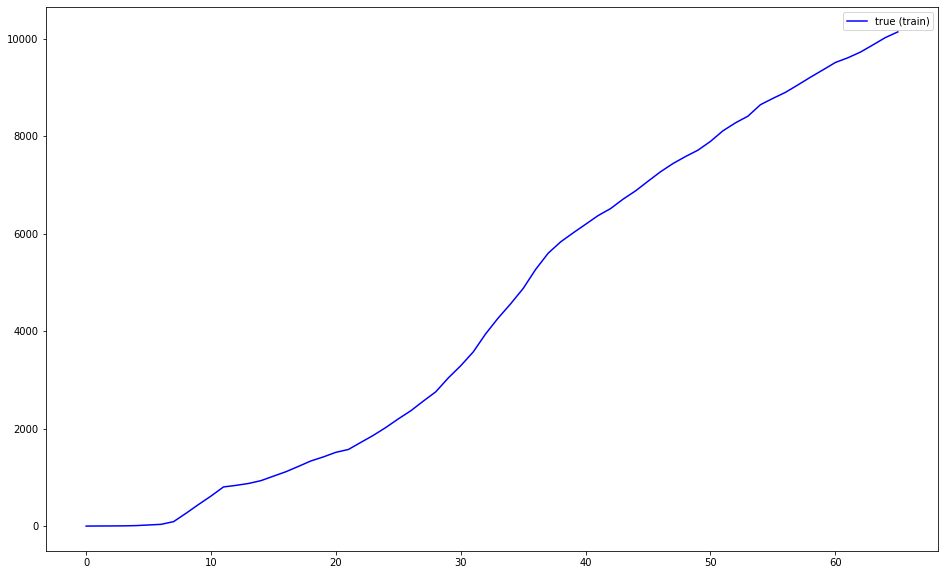

In [0]:
plt.plot(range(T), observed, "b-")
plt.legend(["true (train)"])
plt.show()

How about doing the same with the daily confirmed.

In [0]:
observed_daily = covid19_dk.loc[:, 'Confirmed_daily'].to_numpy()

In [0]:
T = len(observed_daily)
T_forecast = 10

In [0]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=singlevariate_kf)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, obs=observed_daily)

sample: 100%|██████████| 2000/2000 [00:23<00:00, 83.87it/s, 1023 steps of size 2.05e-03. acc. prob=0.96] 


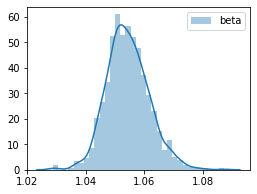

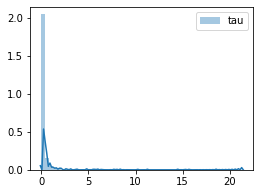

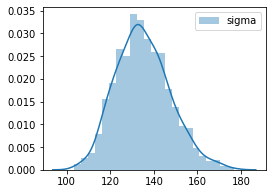

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

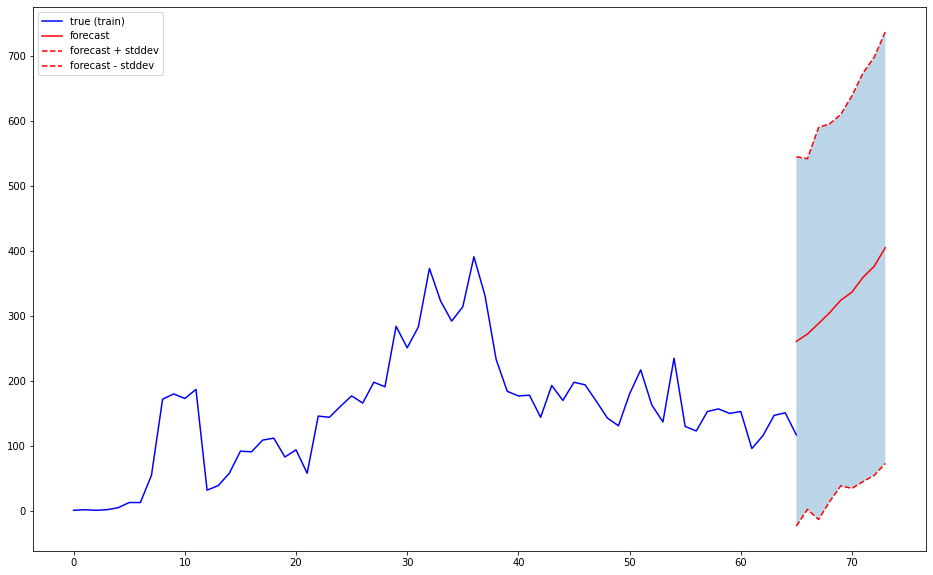

In [0]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

plt.plot(range(T), observed_daily, "b-")
plt.plot(range(T-1, T+T_forecast-2), y_pred_mean, "r-")
plt.plot(range(T-1, T+T_forecast-2), y_pred_025, "r--")
plt.plot(range(T-1, T+T_forecast-2), y_pred_975, "r--")
plt.fill_between(range(T-1, T+T_forecast-2), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

### Multi-variate Kalman Filter

In [0]:
conf_n_deaths = covid19_dk.loc[:, ["Confirmed", "Deaths"]].to_numpy()

In [0]:
T = len(observed)
T_forecast = 15

In [0]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=multivariate_kf)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=15, obs=conf_n_deaths)

sample: 100%|██████████| 2000/2000 [01:01<00:00, 32.33it/s, 1023 steps of size 9.92e-04. acc. prob=0.96]


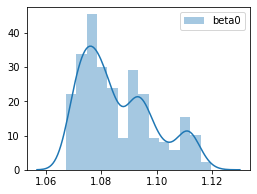

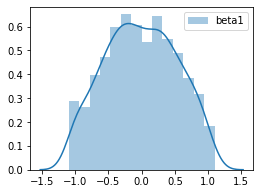

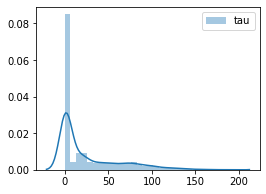

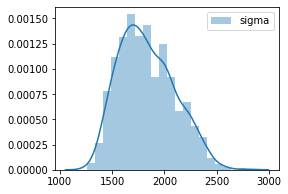

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
# get mean and standard devitions for predictions
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
q = hmc_samples["y_pred1"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

In [0]:
q2 = hmc_samples["y_pred2"]
q_mean2 = q2.mean(axis=0).reshape(-1,)
q_std2 = q2.std(axis=0).reshape(-1,)
y_pred_025_2 = q_mean2 - 1.96*q_std
y_pred_975_2 = q_mean2 + 1.96*q_std
y_pred_mean2 = q_mean2

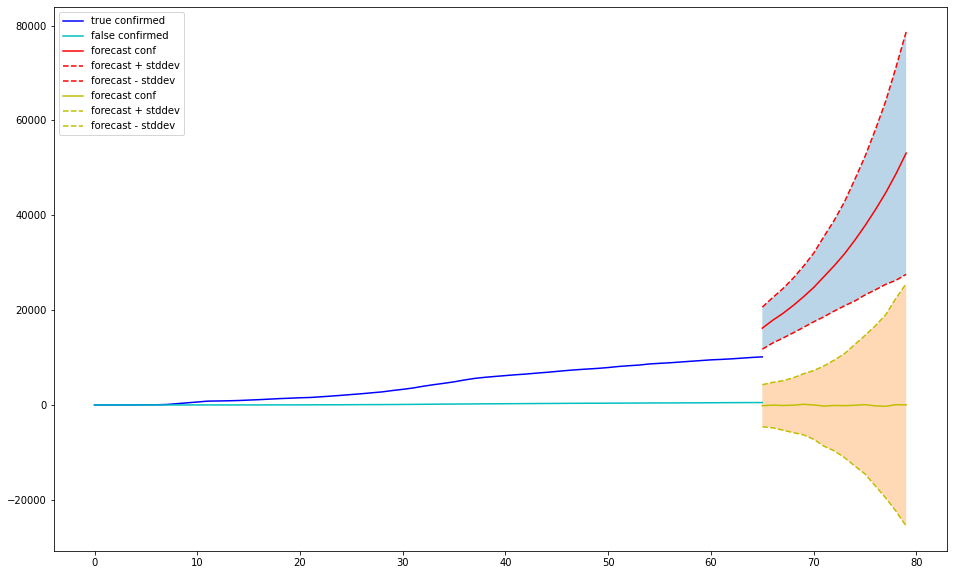

In [0]:
plt.plot(range(T), conf_n_deaths[:,0], "b-")
plt.plot(range(T), conf_n_deaths[:,1], "c-")
plt.plot(range(T, T+T_forecast-2), y_pred_mean, "r-")
plt.plot(range(T, T+T_forecast-2), y_pred_025, "r--")
plt.plot(range(T, T+T_forecast-2), y_pred_975, "r--")
plt.fill_between(range(T, T+T_forecast-2), y_pred_025, y_pred_975, alpha=0.3)
plt.plot(range(T, T+T_forecast-2), y_pred_mean2, "y-")
plt.plot(range(T, T+T_forecast-2), y_pred_025_2, "y--")
plt.plot(range(T, T+T_forecast-2), y_pred_975_2, "y--")
plt.fill_between(range(T, T+T_forecast-2), y_pred_025_2, y_pred_975_2, alpha=0.3)
plt.legend(["true confirmed","false confirmed", "forecast confirmed", "forecast + stddev","forecast - stddev","forecast deaths","forecast + stddev","forecast - stddev"])
plt.show()

### Kalman filter with input

In [0]:
def f(carry, noise_t, x):
  W = np.array([[1,1,1,1],[0,0,0,0]])
  beta, z_prev, tau = carry
  z_t = beta*z_prev + W @ x + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [0]:
def model(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    print(noises.shape)
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, x, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T, 1], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:, 1], scale=sigma), obs=None)


## JC: Nonlinear functions for extednd kalman filter

Tipically, the g() and f() non-linear functions are in first-order Taylor form, so that they are, in fact, linear and produce gaussian distributions when applied to another gaussian distribution.

In order, to do that, we would need to compute the Jacobian and then do some matrix multiplications to compute the Kalman Gain. Good news, Pyro has that implemented: http://pyro.ai/examples/ekf.html. Bad news, the code is a quite ilegible. I'd suggest to do the easier thing an try to do the lax scanning with directly using the non-linear functions and see what happens.

In [0]:
data_covid19=pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv", parse_dates=['Date'])
covid19_dk = data_covid19[data_covid19['Country'] == 'Denmark']
value=covid19_dk.loc[:,'Confirmed'].diff()
covid19_dk.loc[:, 'Confirmed_daily'] = value
covid19_dk=covid19_dk[covid19_dk['Confirmed_daily']>0]
y_obs=covid19_dk['Confirmed_daily']

In [0]:
# sigmoid cumulative data can be generated from a gaussian distribution
def sigmoid(x):
    """Compute sigmoid function."""
    return 1/(1 + np.exp(-x))

def sin(x):
    """Computer sin."""
    # Fail earlier if np is not imported
    return np.sin(x)

def f_ext(carry, noise_t, f=sigmoid):
    """Lax scan."""
    beta, z_prev, tau = carry
    z_t = f(beta*z_prev) + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def ekf(T, T_forecast, f=sigmoid, g=sin, obs=None):
    """Extend a KF."""
    # take into account that we use obs in R>2 (we have more than one variable)
    # we have to change this accordingly

    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T+T_forecast-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=.1))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) and missing y (y_mis)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection, scale=sigma), obs=obs)

## P.K: Look on other GitHub reports of SIR to steal their models, make table for mobility data and infected data for specific country
## JC: Proper forecasting on subset of ground truth, some refactoring of plots, make use of TA to discuss $\tau$ and non-linear functions
## JV: priors for W and make the KF work with mobility data (discuss on Tuesday with TA)
